#  スパッタリング率のプロット

In [20]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
path2data = "/Users/y1u0d2/Downloads"
# path2data = "/Users/y1u0d2/Google Drive/マイドライブ/HamaLab_kotani/sputtering"
data_filename = "sp.xlsx"
# sheet_name = "si_self_substrate_size"
sheet_name = "si_self_sw_size"

In [22]:
# read excel file
sy_df = pd.read_excel(os.path.join(path2data, data_filename), sheet_name=sheet_name)

In [23]:
sy_df

,potential,energy,sy_ion_dose,sy_depo_ion_dose,path,height
0,SW,200,0,-0.714830,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,8.145
1,SW,500,0,-0.481962,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,8.145
2,SW,750,0,-0.394687,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,8.145
3,SW,1000,0,-0.253152,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,8.145
4,SW,200,0,-0.744251,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,10.860
5,SW,500,0,-0.490326,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,10.860
6,SW,750,0,-0.386521,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,10.860
7,SW,1000,0,-0.274951,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,10.860
8,SW,200,0,-0.761572,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,13.575
9,SW,500,0,-0.496096,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,13.575


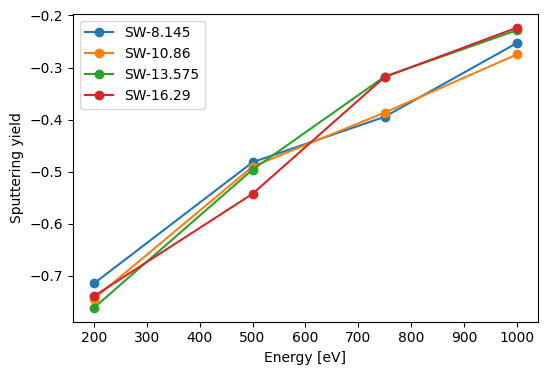

In [24]:
# スパッタリング率のプロット
fig, ax = plt.subplots(figsize=(6, 4))

for height in sy_df["height"].unique():
    ax.plot(
        sy_df[sy_df["height"] == height]["energy"],
        sy_df[sy_df["height"] == height]["sy_depo_ion_dose"],
        marker="o",
        label=f"SW-{height}",
    )
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Sputtering yield")
ax.legend()

In [25]:
sy_df

,potential,energy,sy_ion_dose,sy_depo_ion_dose,path,height
0,SW,200,0,-0.714830,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,8.145
1,SW,500,0,-0.481962,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,8.145
2,SW,750,0,-0.394687,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,8.145
3,SW,1000,0,-0.253152,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,8.145
4,SW,200,0,-0.744251,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,10.860
5,SW,500,0,-0.490326,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,10.860
6,SW,750,0,-0.386521,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,10.860
7,SW,1000,0,-0.274951,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,10.860
8,SW,200,0,-0.761572,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,13.575
9,SW,500,0,-0.496096,/Users/y1u0d2/desktop/Lab/result/lammps/Si/spu...,13.575
